In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import trange
from scipy.stats import norm
from loguru import logger

import os

In [2]:
class Config(object):
    def __init__(self):
        self.seed = 42
        self.n = 1000        # Number of labeled samples
        self.p = 10          # Number of features
        self.alpha = 0.05    # Significance level
        self.n_iter = 100
        self.savedir = 'results'
        self.verbose = True

        if not os.path.exists(self.savedir):
            os.makedirs(self.savedir)

In [3]:
def generate_data(n, m, p):
    X_labeled = np.random.randn(2 * n, p)
    X_unlabeled = np.random.randn(m, p)
    beta = np.random.randn(p)
    assert p >= 3, "p must be greater than or equal to 3"
    # Make first feature irrelevant
    beta[0] = 0
    # The second and third features are correlated with target
    beta[1] = 0.05
    beta[2] = 0.1

    # Fix variance of noise as 1
    y = X_labeled @ beta + np.random.randn(2 * n)
    return X_labeled, X_unlabeled, y

In [4]:
def fit_ols(X, y):
    beta_ols = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta_ols

In [5]:
def hypothesis_testing(X, y, beta_ols, alpha):
    # Since we fixed the variance as known
    se = np.sqrt(np.diag(np.linalg.inv(X.T @ X)))
    z_stat = beta_ols / se
    p_values = 2 * (1 - norm.cdf(np.abs(z_stat)))
    return p_values

In [6]:
def run_simulation(config):
    np.random.seed(config.seed)
    n = config.n
    p = config.p
    alpha = config.alpha
    m_var = [100, 500, 1000, 1500, 2000, 2500, 3000]  # varying number of unlabeled samples
    
    results = pd.DataFrame()
    for m in m_var:
        print(f"Running simulation for m = {m}")
        type_I_error_feat_0 = np.zeros(config.n_iter)
        power_feat_1 = np.zeros(config.n_iter)
        power_feat_2 = np.zeros(config.n_iter)
        for i in trange(config.n_iter):    
            X_labeled, X_unlabeled, y = generate_data(n, m, p)
            # X_labeled_ols, y_ols for fitting OLS model
            # X_labeled_rest, y_rest combined with X_unlabeled for hypothesis testing
            X_labeled_ols, X_labeled_rest = X_labeled[:n], X_labeled[n:]
            y_ols, y_rest = y[:n], y[n:]

            # Fit OLS model        
            beta_ols = fit_ols(X_labeled_ols, y_ols)

            # Predict on unlabeled data
            y_unlabeled_pred = X_unlabeled @ beta_ols

            # Combine labeled and unlabeled data
            X = np.vstack([X_labeled_rest, X_unlabeled])
            y = np.hstack([y_rest, y_unlabeled_pred])

            # Fit new model on combined data and perform hypothesis testing
            beta_ols_combined = fit_ols(X, y)
            p_values = hypothesis_testing(X, y, beta_ols_combined, alpha)

            # Check if null hypothesis is rejected for first 3 feature
            # First feature is irrelevant, second and third are correlated with target
            type_I_error_feat_0[i] = p_values[0] < alpha
            power_feat_1[i] = p_values[1] < alpha
            power_feat_2[i] = p_values[2] < alpha

        # Save average type I error and power
        type_I_error_feat_0 = np.mean(type_I_error_feat_0)
        power_feat_1 = np.mean(power_feat_1)
        power_feat_2 = np.mean(power_feat_2)
        logger.info(f"m = {m}, Type I error (feature 0) = {type_I_error_feat_0}, Power (feature 1) = {power_feat_1}, Power (feature 2) = {power_feat_2}")
        results[m] = {
            'type_I_error_feat_0': type_I_error_feat_0,
            'power_feat_1': power_feat_1,
            'power_feat_2': power_feat_2
        }

    results.to_csv(os.path.join(config.savedir, 'results.csv'))
    return results

In [7]:
result = run_simulation(Config())

Running simulation for m = 100


100%|██████████| 100/100 [00:00<00:00, 1903.23it/s]
2024-06-18 14:37:25.795 | INFO     | __main__:run_simulation:45 - m = 100, Type I error (feature 0) = 0.04, Power (feature 1) = 0.34, Power (feature 2) = 0.9


Running simulation for m = 500


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1250.60it/s]
2024-06-18 14:37:25.878 | INFO     | __main__:run_simulation:45 - m = 500, Type I error (feature 0) = 0.02, Power (feature 1) = 0.53, Power (feature 2) = 0.99


Running simulation for m = 1000


100%|██████████| 100/100 [00:00<00:00, 1543.66it/s]
2024-06-18 14:37:25.945 | INFO     | __main__:run_simulation:45 - m = 1000, Type I error (feature 0) = 0.03, Power (feature 1) = 0.65, Power (feature 2) = 0.99


Running simulation for m = 1500


100%|██████████| 100/100 [00:00<00:00, 1272.19it/s]
2024-06-18 14:37:26.025 | INFO     | __main__:run_simulation:45 - m = 1500, Type I error (feature 0) = 0.09, Power (feature 1) = 0.71, Power (feature 2) = 1.0


Running simulation for m = 2000


100%|██████████| 100/100 [00:00<00:00, 1226.11it/s]
2024-06-18 14:37:26.108 | INFO     | __main__:run_simulation:45 - m = 2000, Type I error (feature 0) = 0.11, Power (feature 1) = 0.7, Power (feature 2) = 0.99


Running simulation for m = 2500


100%|██████████| 100/100 [00:00<00:00, 1125.87it/s]
2024-06-18 14:37:26.199 | INFO     | __main__:run_simulation:45 - m = 2500, Type I error (feature 0) = 0.2, Power (feature 1) = 0.73, Power (feature 2) = 1.0


Running simulation for m = 3000


100%|██████████| 100/100 [00:00<00:00, 999.23it/s]
2024-06-18 14:37:26.301 | INFO     | __main__:run_simulation:45 - m = 3000, Type I error (feature 0) = 0.2, Power (feature 1) = 0.76, Power (feature 2) = 0.99


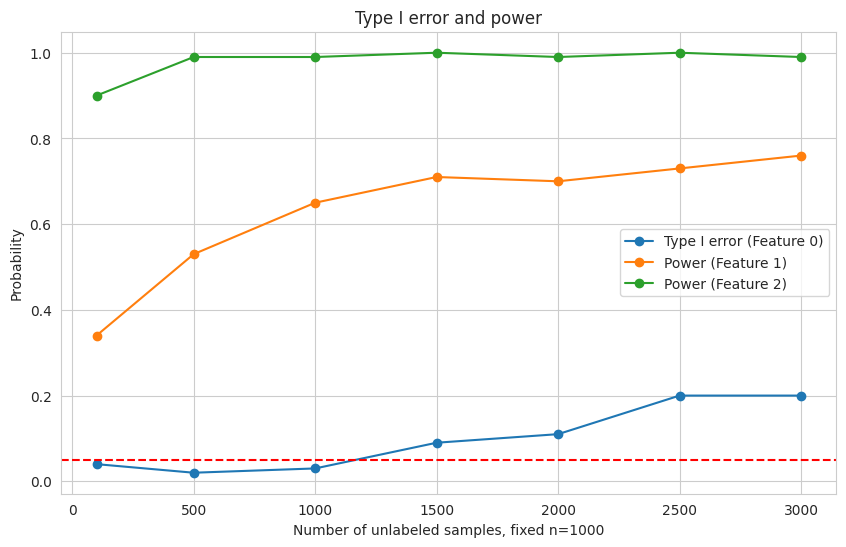

In [8]:
type_I_error_feat_0 = result.loc['type_I_error_feat_0']
power_feat_1 = result.loc['power_feat_1']
power_feat_2 = result.loc['power_feat_2']
# plot results
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.color_palette("hls", 8)
plt.plot(result.columns, type_I_error_feat_0, marker='o')
plt.plot(result.columns, power_feat_1, marker='o')
plt.plot(result.columns, power_feat_2, marker='o')
plt.axhline(0.05, color='r', linestyle='--')
plt.xlabel('Number of unlabeled samples, fixed n=1000')
plt.ylabel('Probability')
plt.title('Type I error and power')
plt.legend(['Type I error (Feature 0)', 'Power (Feature 1)', 'Power (Feature 2)'])
plt.savefig(os.path.join(Config().savedir, 'results.pdf'), format='pdf')